## The Anime Recommendation system
The Anime Recommendation system is one of the best projects as it includes a data set 
containing information regarding user preference from 73,516 users on 12,294 anime. 
Every user in the database will be able to add anime to the list and share ratings 
compiling a data set with those ratings. The anime recommendation system project helps 
in creating a system that produces efficient data based on the user viewing history and 
sharing rating.
Dataset:
https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

# Content
### Anime.csv
| Column | Description |
|--------|-------------|
| anime_id | myanimelist.net's unique id identifying an anime |
| name | Full name of anime |
| genre | Comma-separated list of genres for this anime |
| type | Type of anime (movie, TV, OVA, etc.) |
| episodes | Number of episodes in this show (1 if movie) |
| rating | Average rating out of 10 for this anime |
| members | Number of community members that are in this anime's "group" |


### Rating.csv
| Column | Description |
|--------|-------------|
| user_id | Non-identifiable randomly generated user id |
| anime_id | The anime that this user has rated |
| rating | Rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating) |


### **Things to put light on**
<li>The connection between Anime and rates is the anime id
<li>REMEMBER!! rating in anime data is the total rates have happened to this data, but rating in the second table is specific for some user , means by that user number 1 has rated with 5 for anime, and the same anime has about 59 rates and all of them about 9.38 rate

In [1]:
import re
import statistics
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from tabulate import tabulate
import tkinter as tk
from tkinter import filedialog
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [2]:
root = tk.Tk()
root.withdraw() # hide the root window
file_path_of_anime = filedialog.askopenfilename() # show the file dialog box and wait for user selection

In [3]:
file_path_of_rating = filedialog.askopenfilename() # show the file dialog box and wait for user selection
print(file_path_of_anime,file_path_of_rating,sep="\n") # print the path of the selected file

C:/Users/umahm/OneDrive/Desktop/Projects Github/Data-Mining/anime.csv
C:/Users/umahm/OneDrive/Desktop/Projects Github/Data-Mining/rating.csv


In [4]:
def wrangle(path_rating, path_anime):
    rating = pd.read_csv(path_rating)
    anime = pd.read_csv(path_anime)
    
    # Print head values
    print("Head Values of Rating:")
    print(tabulate(rating.head(), headers='keys', tablefmt='fancy_grid'))
    print("\nHead Values of Anime:")
    print(anime.head())
    
    # Print info of data
    print("\nThe needed Info of Rating:")
    print(rating.info())
    print("\nThe needed Info of Anime:")
    print(anime.info())

    # Print statistical data
    print("\nStatistical data about Ratings:")
    print(tabulate(rating.describe().T, headers='keys', tablefmt='fancy_grid'))
    print("\nStatistical data about Anime:")
    print(tabulate(anime.describe().T, headers='keys', tablefmt='fancy_grid'))

    # Print nullity before cleaning
    print("\nNullity before cleaning in Rating:")
    print(tabulate(rating.isnull().sum().to_frame().T, headers='keys', tablefmt='fancy_grid'))
    print("\nNullity before cleaning in Anime:")
    print(tabulate(anime.isnull().sum().to_frame().T, headers='keys', tablefmt='fancy_grid'))
    
    # Drop null values
    rating = rating.dropna()
    anime = anime.dropna()
    
    # Print nullity after cleaning
    print("\nNullity after cleaning in Rating:")
    print(tabulate(rating.isnull().sum().to_frame().T, headers='keys', tablefmt='fancy_grid'))
    print("\nNullity after cleaning in Anime:")
    print(tabulate(anime.isnull().sum().to_frame().T, headers='keys', tablefmt='fancy_grid'))
    
    # converting data of -1 people to NaN
    rating.rating.replace({-1: np.nan}, regex=True, inplace = True)
    
    # Print duplications
    print(f"There are {rating[rating.duplicated()].shape[0]} duplicate rows in {rating.shape[0]} rows in rating dataset.")
    rating.drop_duplicates(inplace=True)
    print(f"There are now {rating[rating.duplicated()].shape[0]} duplicate rows after process of duplication in {rating.shape[0]} rows in rating dataset.")  
    print(f"There are {anime[anime.duplicated()].shape[0]} duplicate rows in {anime.shape[0]} rows in anime dataset.")
    anime.drop_duplicates(inplace=True)
    print(f"There are now {anime[anime.duplicated()].shape[0]} duplicate rows after process of duplication in {anime.shape[0]} rows in rating dataset.")  
    
    # Clean function
    def clean_name(text):
        text = re.sub(r'.hack//','',text)
        text = re.sub(r'&quot;', '', text)
        text = re.sub(r'&amp;','',text)
        return text
    
    # Clean names
    anime["name"] = anime["name"].apply(clean_name)
    
    # Merge data frames
    Data = pd.merge(anime, rating, on="anime_id")
    Data = Data.rename(columns={"rating_x": "Average_Rating", "rating_y": "Rate_of_user"})
    
    # 
    return Data


In [5]:
Data = wrangle(path_rating=file_path_of_rating,path_anime=file_path_of_anime)
Data

Head Values of Rating:
╒════╤═══════════╤════════════╤══════════╕
│    │   user_id │   anime_id │   rating │
╞════╪═══════════╪════════════╪══════════╡
│  0 │         1 │         20 │       -1 │
├────┼───────────┼────────────┼──────────┤
│  1 │         1 │         24 │       -1 │
├────┼───────────┼────────────┼──────────┤
│  2 │         1 │         79 │       -1 │
├────┼───────────┼────────────┼──────────┤
│  3 │         1 │        226 │       -1 │
├────┼───────────┼────────────┼──────────┤
│  4 │         1 │        241 │       -1 │
╘════╧═══════════╧════════════╧══════════╛

Head Values of Anime:
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Dram

,anime_id,name,genre,type,episodes,Average_Rating,members,user_id,Rate_of_user
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,NaN
...,...,...,...,...,...,...,...,...,...
7813605,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,39532,NaN
7813606,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,48766,NaN
7813607,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,60365,4.0
7813608,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,27364,NaN


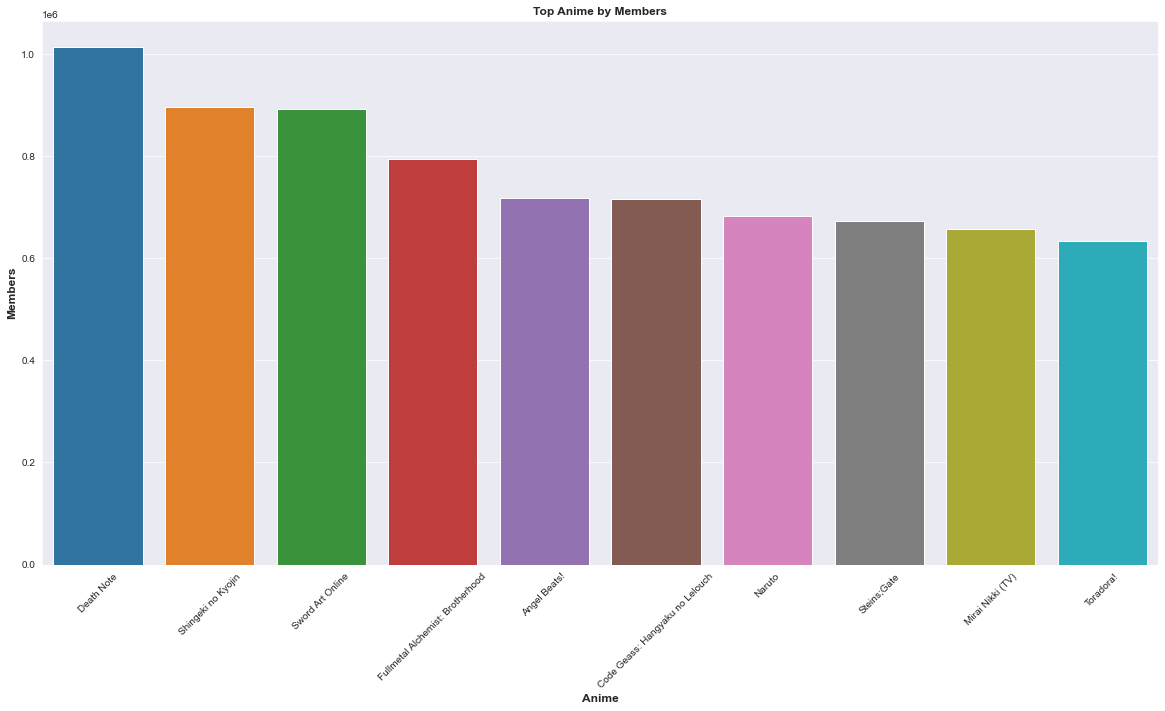

In [6]:
# Let's see top animes
top_animes = Data.drop_duplicates(subset="name",keep="first").sort_values("members",ascending=False)

ax,figure = plt.subplots(figsize=(20,10))
bar_plot = sns.barplot(data=top_animes.head(10), x="name", y="members")

plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.xlabel('Anime',fontsize=12, fontweight='bold')
plt.ylabel('Members',fontsize=12, fontweight='bold')
plt.title('Top Anime by Members',fontsize=12, fontweight='bold')

plt.show()

## From this draw, Death note was the most watched anime, then Attack on titan, and SAO
so will take their generes to know if people like same generies

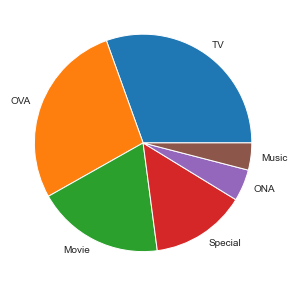

In [7]:
top_types = top_animes.sort_values(["members"],ascending=False)
top_types_group = top_types["type"].value_counts().squeeze()
ax,figure = plt.subplots(figsize=(5,5))
plt.pie(top_types_group,labels=top_types_group.index);

In [8]:
def Viz_Anime(data=top_types, type_of_movie="TV"):
    fig, axs = plt.subplots(figsize=(20, 8))
    sns.histplot(data[data["type"] == type_of_movie]["Average_Rating"], color="green", kde=True, ax=axs, bins=20, alpha=1, fill=True, edgecolor="black")
    axs.lines[0].set_color("blue")
    axs.set_title(f"\nAnime's Average Ratings Distribution [Category: {type_of_movie}]\n", fontsize=20)
    axs.set_xlabel("Rating")
    axs.set_ylabel("Total")
    axs.set_xticks(np.arange(2, 9, step=0.5))  # Set label locations.
    plt.show()
    
def Viz_User(data=Data, type_of_movie="TV"):
    fig, axs = plt.subplots(figsize=(20, 8))
    sns.histplot(data[data["type"] == type_of_movie]["Rate_of_user"], color="red", kde=True, ax=axs, bins="auto", alpha=1, fill=True, edgecolor="black")
    axs.lines[0].set_color("blue")
    axs.set_title(f"\nUsers Anime Ratings Distribution [Category: {type_of_movie}]\n", fontsize=20)
    axs.set_xlabel("Rating")
    axs.set_ylabel("Total")
    axs.set_xticks(np.arange(2, 9, step=0.5))  # Set label locations.
    plt.show()


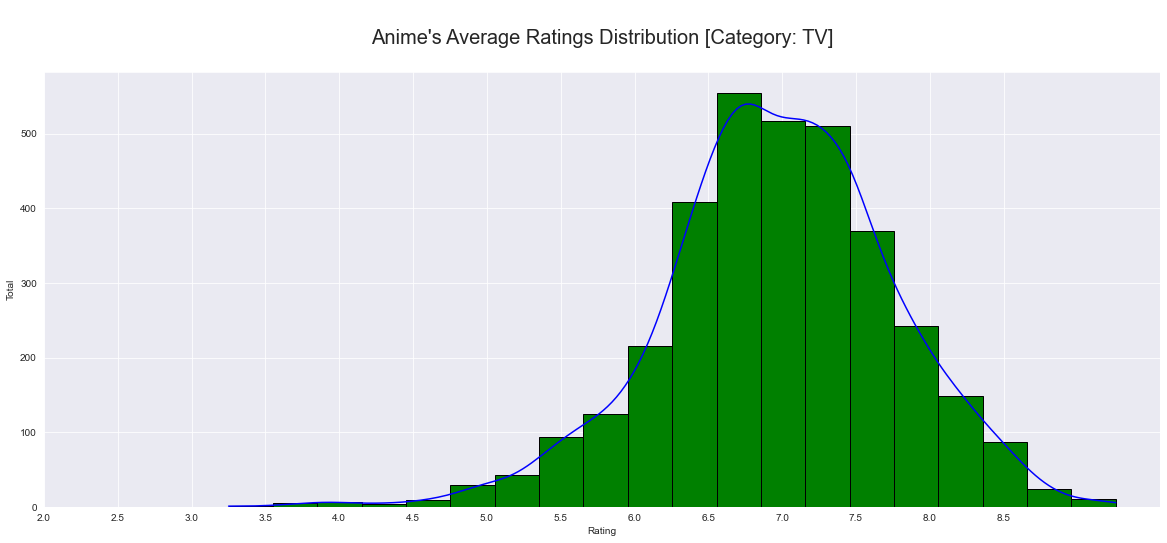

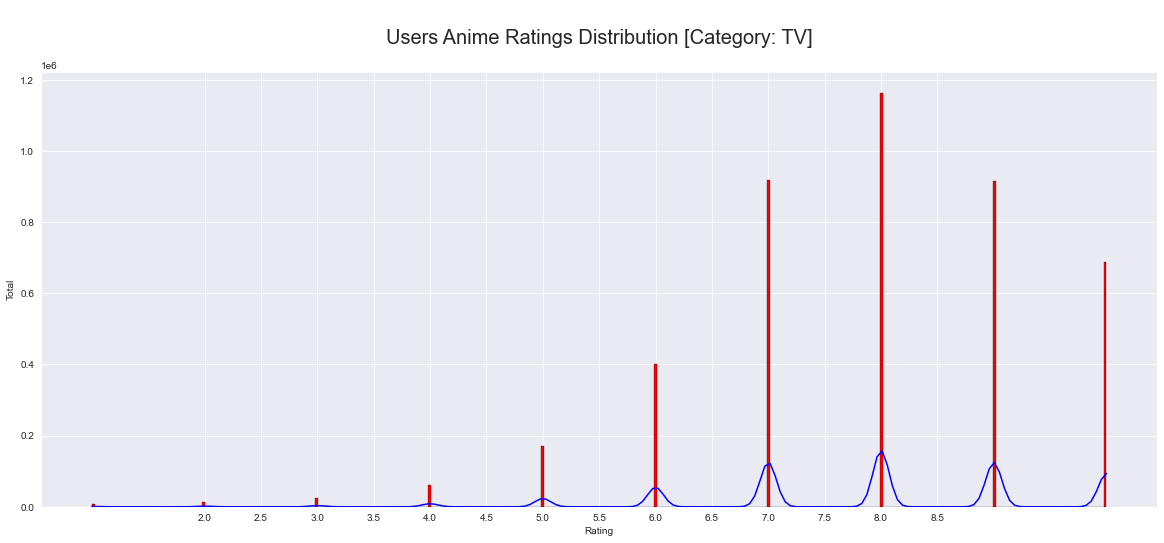

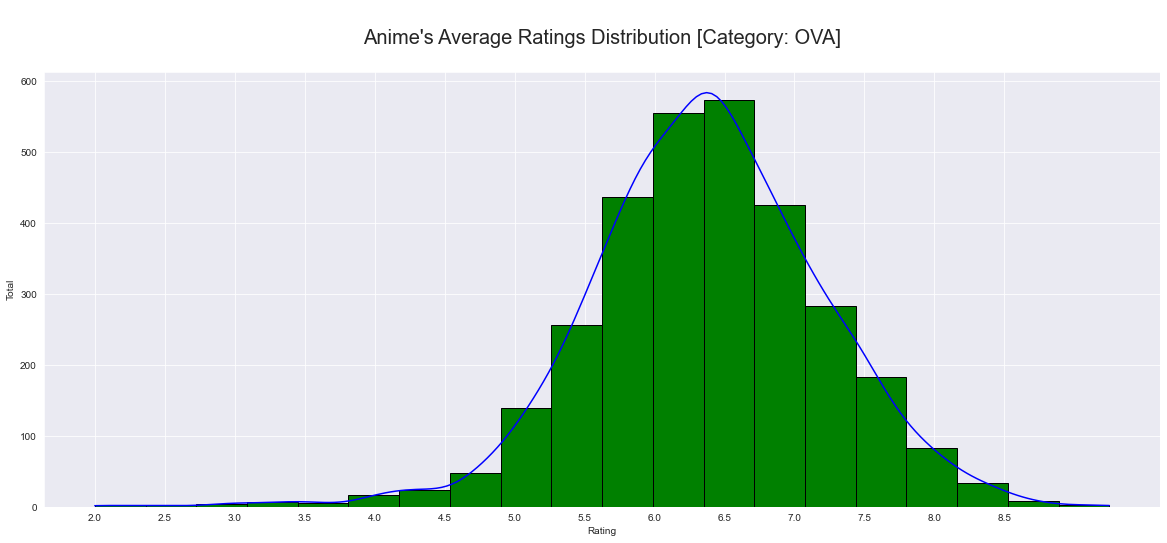

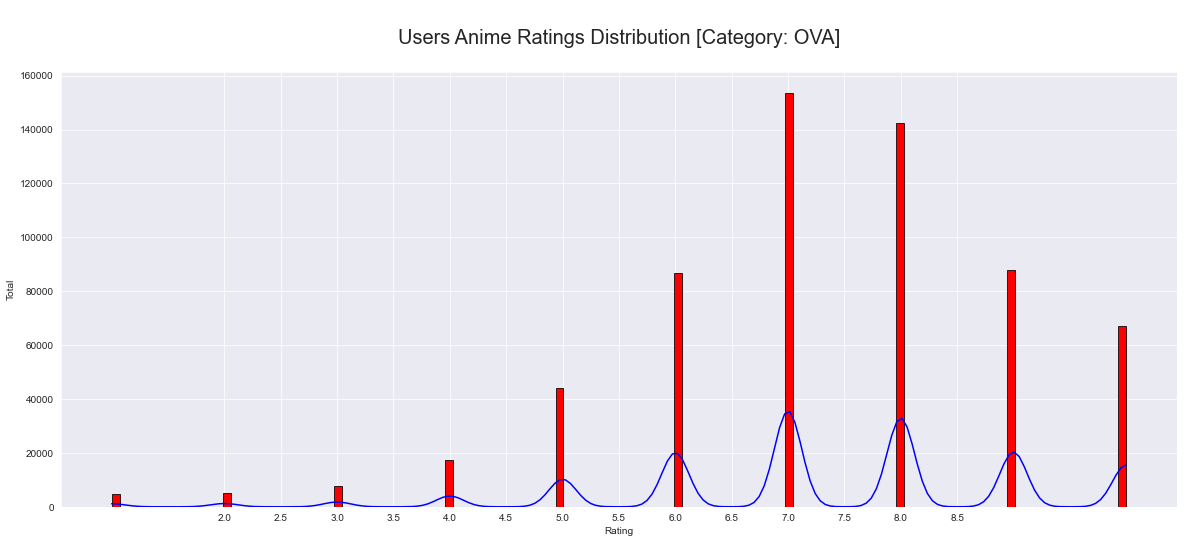

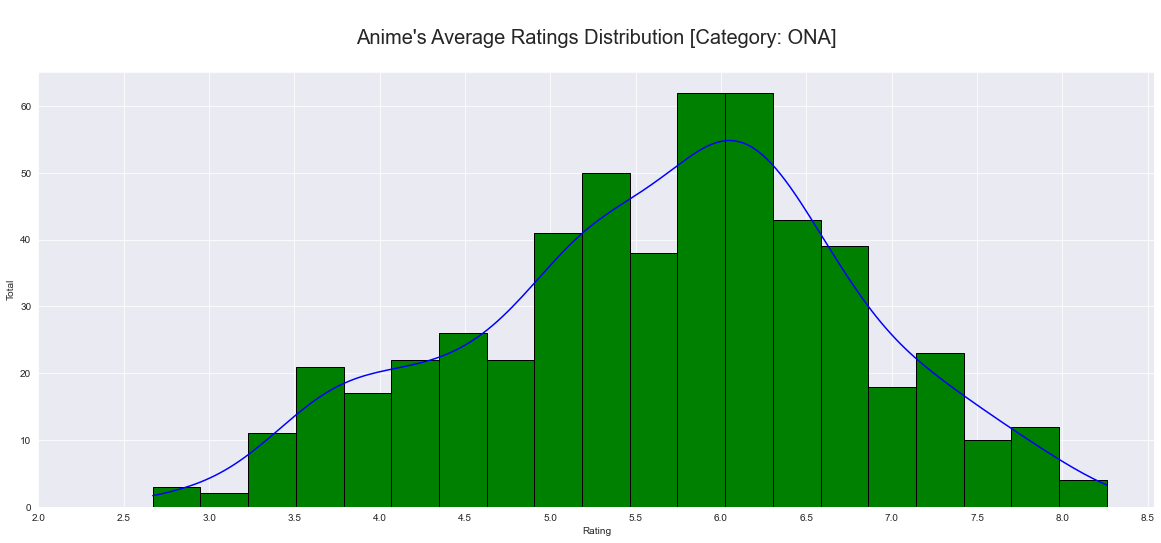

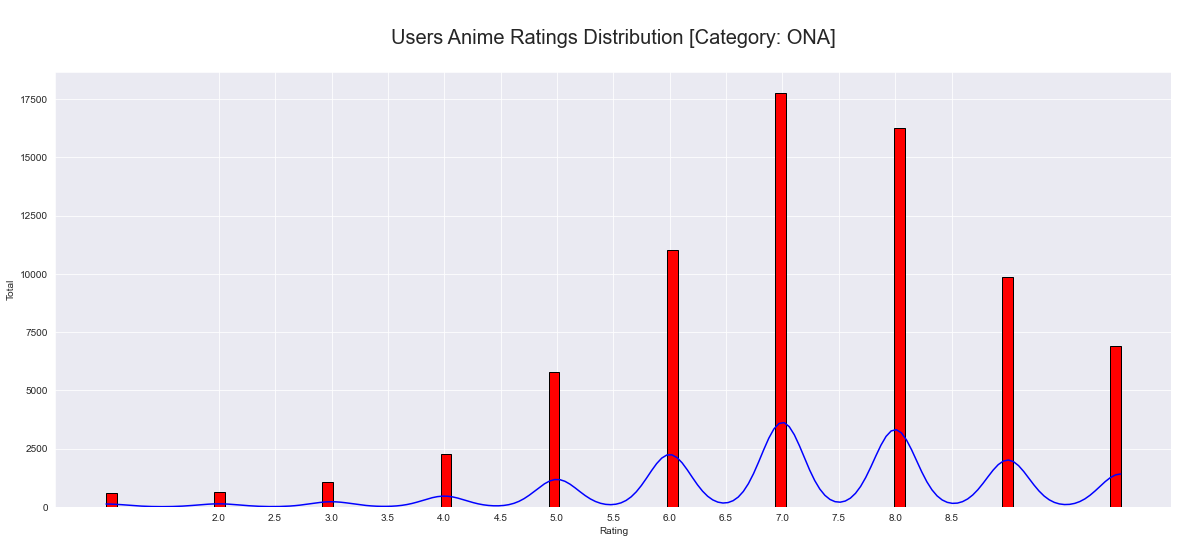

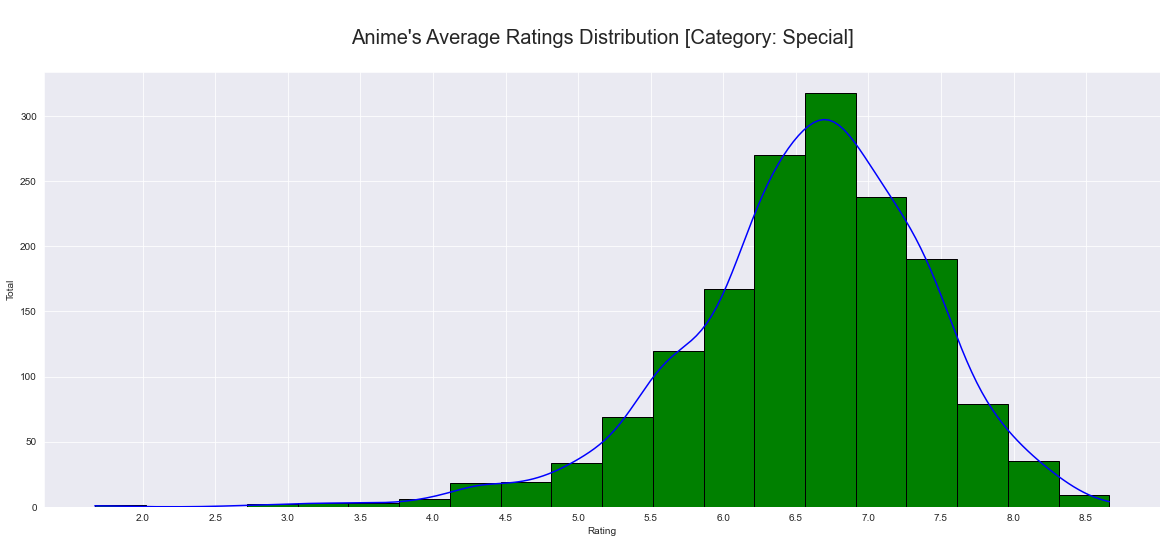

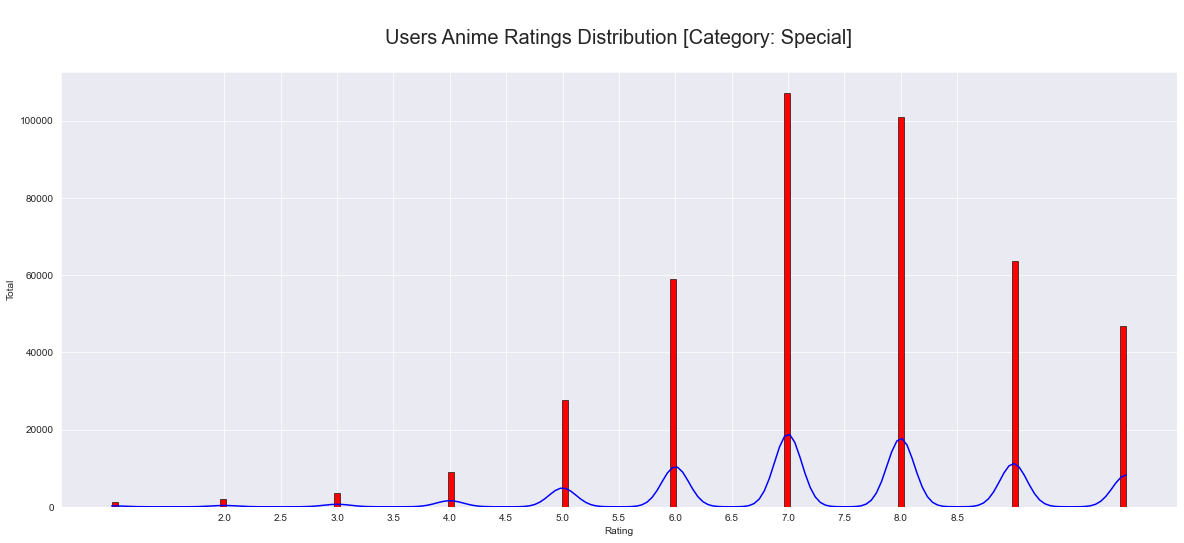

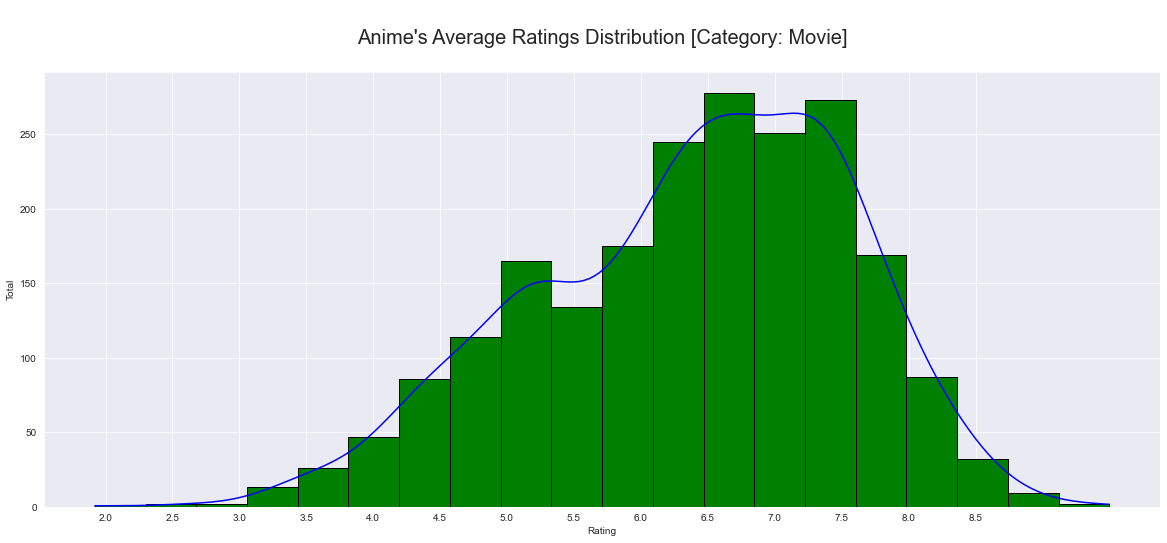

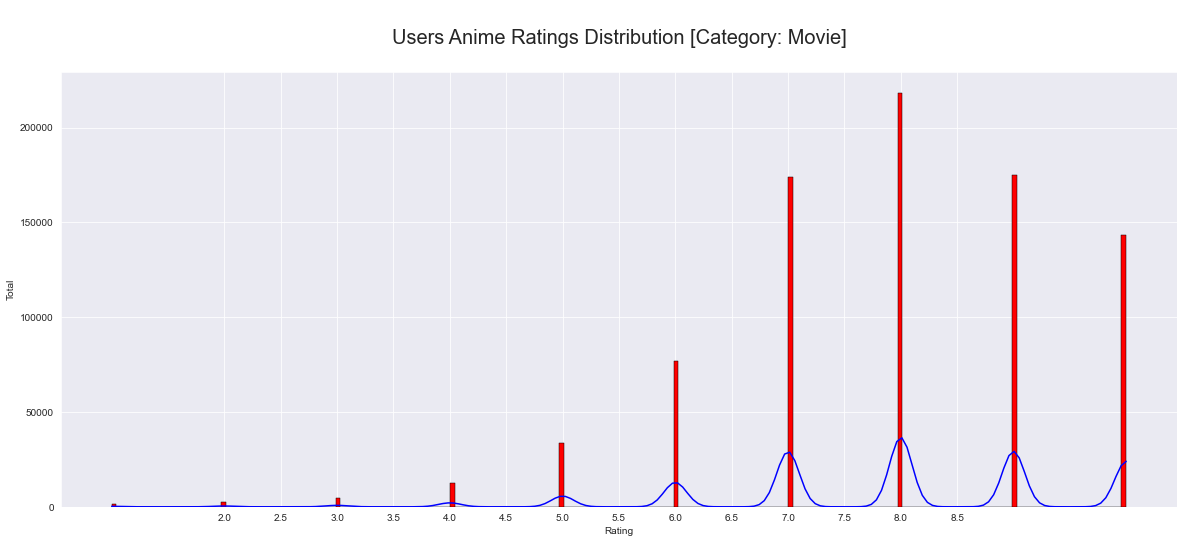

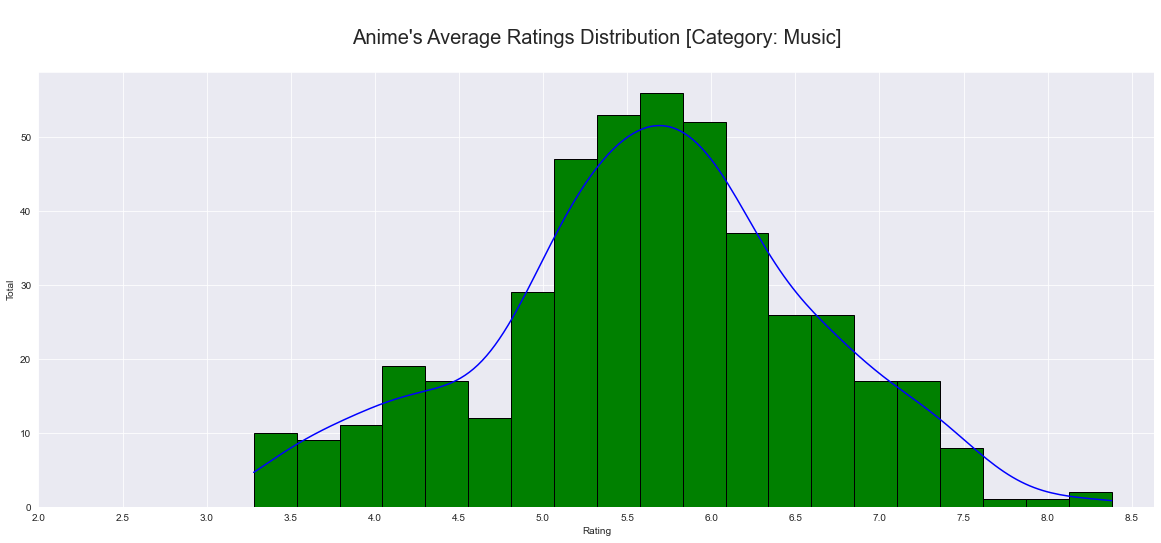

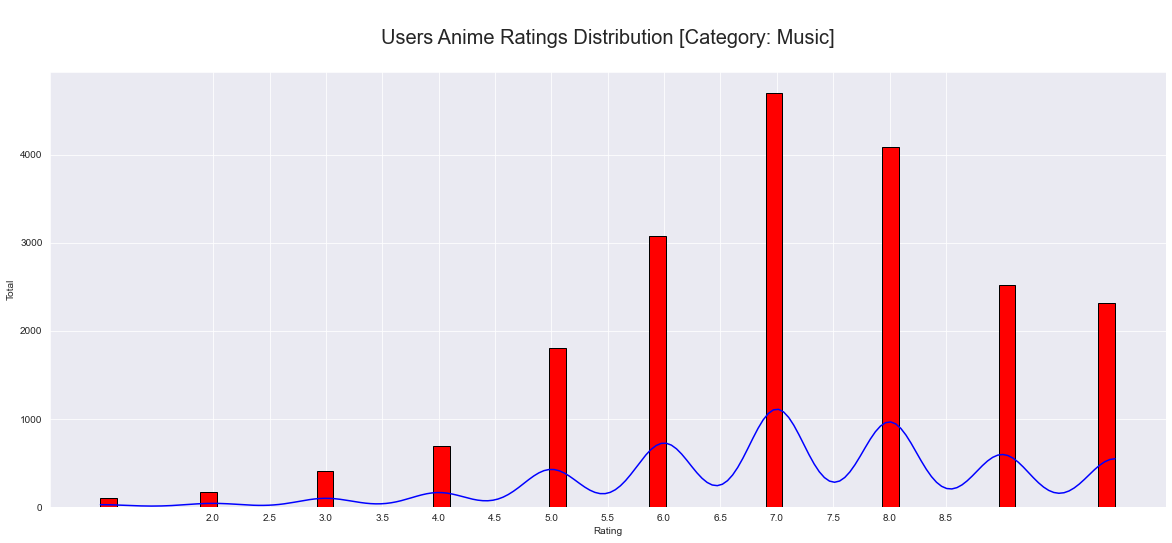

In [9]:
# Draw for Categories
Viz_Anime(data=top_types,type_of_movie="TV")
Viz_User(data=Data,type_of_movie="TV")

Viz_Anime(data=top_types,type_of_movie="OVA")
Viz_User(data=Data,type_of_movie="OVA")

Viz_Anime(data=top_types,type_of_movie="ONA")
Viz_User(data=Data,type_of_movie="ONA")

Viz_Anime(data=top_types,type_of_movie="Special")
Viz_User(data=Data,type_of_movie="Special")

Viz_Anime(data=top_types,type_of_movie="Movie")
Viz_User(data=Data,type_of_movie="Movie")

Viz_Anime(data=top_types,type_of_movie="Music")
Viz_User(data=Data,type_of_movie="Music")

# Insights have been taken from this data
| Category | Average Rating Range | Users' Rating Range | Most Common Rating |
|----------|---------------------|--------------------|--------------------|
| TV       | 6-8                 | 6-10               | 8                  |
| OVA      | 5.5-7               | 6-9                | 7                  |
| ONA      | 4-7.5               | 5-9                | 7                  |
| Movie    | 4.5-8               | 6-10               | 8                  |
| Special  | 5.5-7.5             | 5-9                | 7                  |
| Music    | 3.5-6.5             | 5-10               | 7                  |

That means we need to put full foucs on **TV** and **Movie** If we need to make sure of our accuracy in similarities 

In [10]:
# What aboue generies ? 
top_genere = top_animes[["genre"]]

top_genere["genre"] = top_genere["genre"].str.split(", | , | ,")

top_genere = top_genere.explode("genre")

top_genere["genre"] = top_genere["genre"].str.title()

print(f"Unique Values of Genries = {len(top_genere['genre'].unique())}, and they are : ")

for i,value in enumerate(top_genere['genre'].unique()):
    print(f"{i+1}-{value}")

Unique Values of Genries = 43, and they are : 
1-Mystery
2-Police
3-Psychological
4-Supernatural
5-Thriller
6-Action
7-Drama
8-Fantasy
9-Shounen
10-Super Power
11-Adventure
12-Game
13-Romance
14-Magic
15-Military
16-Comedy
17-School
18-Mecha
19-Sci-Fi
20-Martial Arts
21-Slice Of Life
22-Horror
23-Seinen
24-Ecchi
25-Demons
26-Parody
27-Space
28-Vampire
29-Dementia
30-Historical
31-Harem
32-Shoujo
33-Music
34-Samurai
35-Sports
36-Kids
37-Josei
38-Shoujo Ai
39-Shounen Ai
40-Cars
41-Hentai
42-Yaoi
43-Yuri


In [11]:
top_gener_dic = top_genere["genre"].value_counts().to_dict()

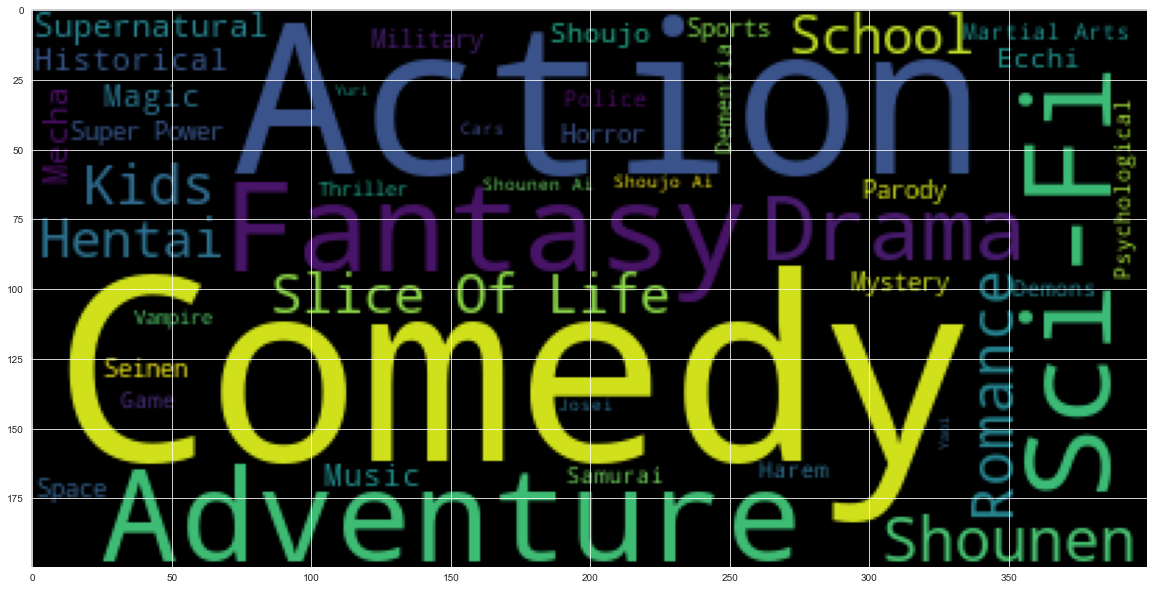

In [12]:
from wordcloud import WordCloud

wc = WordCloud()
ax,fig = plt.subplots(figsize=(20,20))

text = wc.generate_from_frequencies(top_gener_dic)
plt.imshow(text);

In [13]:
Training , _ = train_test_split(Data, test_size=0.3, random_state=42)

In [14]:
User_Vs_Anime = pd.pivot_table(data=Training,index="user_id",columns="name",values="Rate_of_user").T

In [15]:
User_Vs_Anime_dense = User_Vs_Anime.replace({np.nan:0})
User_Vs_Anime_dense

user_id,1,3,5,7,8,10,11,12,14,15,...,73506,73507,73508,73509,73510,73511,73512,73513,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009 Re:Cyborg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009-1: RB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xxxHOLiC Kei,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xxxHOLiC Movie: Manatsu no Yoru no Yume,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xxxHOLiC Rou,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
MM = MinMaxScaler()
User_Vs_Anime_dense_fit = MM.fit_transform(User_Vs_Anime_dense)
User_Vs_Anime_dense_normalized = pd.DataFrame(User_Vs_Anime_dense_fit,
                                                  columns=User_Vs_Anime.columns,
                                                  index=User_Vs_Anime.index)

In [17]:
model_matrix = csr_matrix(User_Vs_Anime_dense_normalized.values)
model_knn = NearestNeighbors(metric = "cosine", algorithm = "brute")
model_knn.fit(model_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [18]:
def Anime_Number(x):
    for i in range(len(User_Vs_Anime_dense_normalized)) :
        if (User_Vs_Anime_dense_normalized.index[i] == x) :
            return(i)
            break

In [19]:
def Anime_RecommenderKnn(x):
    Qn = Anime_Number(x)
    
    print(f"We will find recommendations for anime number {Qn}, which is {User_Vs_Anime_dense_normalized.index[Qn]}.")
    
    distances, indices = model_knn.kneighbors(User_Vs_Anime_dense_normalized.iloc[Qn, :].values.reshape(1, -1), n_neighbors=21)
    
    recommended_anime_indices = indices.flatten()[1:]
    
    recommended_anime = User_Vs_Anime_dense_normalized.iloc[recommended_anime_indices, :]
    
    print(f"Recommendations for {User_Vs_Anime_dense_normalized.index[Qn]}:\n")
    
    recommended_df = pd.DataFrame(columns=["Rank", "Anime_KNN"])
    
    for i, (anime_knn, distance) in enumerate(zip(recommended_anime.index, distances.flatten()[1:]), start=1):
        recommended_df = recommended_df.append({"Rank": i, "Anime_KNN": anime_knn}, ignore_index=True)
        print(f"{i}: {anime_knn}")
        
    mse = mean_squared_error(User_Vs_Anime_dense_normalized.iloc[Qn, :], recommended_anime.mean(axis=0))
    print("\nMean Squared Error:", round(mse, 4))
    
    return recommended_df


In [20]:
Anime_KNN = Anime_RecommenderKnn('Tokyo Ghoul')

We will find recommendations for anime number 8591, which is Tokyo Ghoul.
Recommendations for Tokyo Ghoul:

1: Tokyo Ghoul √A
2: Shingeki no Kyojin
3: Akame ga Kill!
4: No Game No Life
5: Noragami
6: Kiseijuu: Sei no Kakuritsu
7: Sword Art Online
8: Sword Art Online II
9: Death Parade
10: Mirai Nikki (TV)
11: Zankyou no Terror
12: One Punch Man
13: Owari no Seraph
14: Black Bullet
15: Ao no Exorcist
16: Nanatsu no Taizai
17: Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka
18: Psycho-Pass
19: Deadman Wonderland
20: Another

Mean Squared Error: 0.0646


In [21]:
KNN = Anime_KNN.sort_values("Anime_KNN").set_index("Rank")

In [22]:
svd = TruncatedSVD(n_components=50, random_state=42)
model_svd = svd.fit_transform(model_matrix)

In [23]:
def Anime_RecommenderSVD(x):
    Qn = Anime_Number(x)
    print(f"We will find recommendations for anime number {Qn}, which is {User_Vs_Anime_dense_normalized.index[Qn]}.")
    anime_vector = model_svd[Qn]

    # Calculate cosine similarities between the anime vector and all other vectors
    similarities = model_svd.dot(anime_vector) / (np.linalg.norm(model_svd, axis=1) * np.linalg.norm(anime_vector))

    # Sort the indices based on similarity (higher values first)
    sorted_indices = np.argsort(similarities)[::-1]

    # Get the top 10 recommended anime indices (excluding the input anime)
    recommended_indices = sorted_indices[1:21]

    recommended_anime = User_Vs_Anime_dense_normalized.iloc[recommended_indices]

    print(f"Recommendations for {User_Vs_Anime_dense_normalized.index[Qn]}:\n")
    
    recommended_df = pd.DataFrame(columns=["Rank", "Anime_SVD"])
    
    for i, anime_svd in enumerate(recommended_anime.index, start=1):
        recommended_df = recommended_df.append({"Rank": i, "Anime_SVD": anime_svd}, ignore_index=True)
        print(f"{i}: {anime_svd}")

    mse = mean_squared_error(User_Vs_Anime_dense_normalized.iloc[Qn, :], recommended_anime.mean(axis=0))
    print("\nMean Squared Error:", round(mse, 4))
    
    return recommended_df

In [24]:
# Call the SVD-based anime recommender
Anime_svd = Anime_RecommenderSVD('Tokyo Ghoul')

We will find recommendations for anime number 8591, which is Tokyo Ghoul.
Recommendations for Tokyo Ghoul:

1: Tokyo Ghoul √A
2: Akame ga Kill!
3: Kiseijuu: Sei no Kakuritsu
4: Death Parade
5: Noragami
6: Zankyou no Terror
7: Sword Art Online II
8: No Game No Life
9: Owari no Seraph
10: Nanatsu no Taizai
11: Black Bullet
12: Ansatsu Kyoushitsu (TV)
13: Psycho-Pass 2
14: Corpse Party: Tortured Souls - Bougyakusareta Tamashii no Jukyou
15: Danganronpa: Kibou no Gakuen to Zetsubou no Koukousei The Animation
16: Noragami Aragoto
17: One Punch Man
18: Mekakucity Actors
19: Hunter x Hunter (2011)
20: Terra Formars

Mean Squared Error: 0.0696


In [25]:
SVD = Anime_svd.sort_values("Anime_SVD").set_index("Rank")

In [26]:
model_kmedoids = KMedoids(n_clusters=14, metric="cosine")

In [27]:
model_kmedoids.fit(model_matrix)

KMedoids(metric='cosine', n_clusters=14)

In [28]:
def Anime_RecommenderKMD(x):
    Qn = Anime_Number(x)
    print(f"We will find recommendations for anime number {Qn}, which is {User_Vs_Anime_dense_normalized.index[Qn]}.")
    
    cluster_indices = model_kmedoids.predict(User_Vs_Anime_dense_normalized.values)
    
    target_cluster = cluster_indices[Qn]
    
    recommended_anime_indices = np.where(cluster_indices == target_cluster)[0]
    
    recommended_anime = User_Vs_Anime_dense_normalized.iloc[recommended_anime_indices, :]
    
    top_10_anime = recommended_anime.head(10)
    
    print(f"Recommendations for {User_Vs_Anime_dense_normalized.index[Qn]}:\n")
    
    for i, index in enumerate(top_10_anime.index, start=1):
        print(f"{i}: {index}")
    mse = mean_squared_error(User_Vs_Anime_dense_normalized.iloc[Qn, :], recommended_anime.mean(axis=0))
    print("\nMean Squared Error:", round(mse, 4))

In [29]:
Anime_RecommenderKMD('Tokyo Ghoul')

We will find recommendations for anime number 8591, which is Tokyo Ghoul.
Recommendations for Tokyo Ghoul:

1: 100%
2: 91 Days
3: Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari
4: Ahiru no Pekkle no Suieitaikai wa Oosawagi
5: Ajin
6: Ajin Part 1: Shoudou
7: Ajin Part 2: Shoutotsu
8: Akagami no Shirayuki-hime
9: Akagami no Shirayuki-hime 2nd Season
10: Akagami no Shirayuki-hime: Nandemonai Takaramono, Kono Page

Mean Squared Error: 0.0966
